In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [124]:
columns = ['app', 'device', 'os', 'channel', 'ip', "is_attributed", 'weight']
df_train = pd.read_hdf('../data/raw/train.hdf.compress', stop=1000000)

In [125]:
df = df_train.sort_values(by=['ip', 'os', 'device', 'click_time'])
df['is_new_session'] = (df['ip']!=df['ip'].shift()) | (df['os']!=df['os'].shift()) | (df['device']!=df['device'].shift()) | (df['click_time'].diff().dt.total_seconds() > 600)
df['session_id'] = df['is_new_session'].cumsum()
df.drop(columns='is_new_session', inplace=True)
# df.groupby('session_id')['is_attributed'].any().value_counts()

In [126]:
df['weight'] = df['is_attributed'] * 100
for c in ['app', 'device', 'os', 'channel', 'ip']:
    df[c] = df[c].astype(float)

In [127]:
train_df = df[columns][:800000]
y_train = train_df.pop('is_attributed')
test_df = df[columns][200000:]
y_test = test_df.pop('is_attributed')

In [128]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(train_df, y_train, num_epochs=None, shuffle=True)
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(train_df, y_train, shuffle=False)
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(test_df, y_test, shuffle=False)

In [133]:
feature_cols = [tf.feature_column.numeric_column(c) for c in  ['app', 'device', 'os', 'channel', 'ip']]

In [134]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=feature_cols,
    n_classes=2,
    weight_column=tf.feature_column.numeric_column('weight'),
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppu9z6bc1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f17a7390780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [135]:
estimator.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmppu9z6bc1/model.ckpt.
INFO:tensorflow:loss = 0.0, step = 1
INFO:tensorflow:global_step/sec: 236.293
INFO:tensorflow:loss = 0.0, step = 101 (0.425 sec)
INFO:tensorflow:global_step/sec: 270.835
INFO:tensorflow:loss = 0.0, step = 201 (0.369 sec)
INFO:tensorflow:global_step/sec: 273.312
INFO:tensorflow:loss = 0.0, step = 301 (0.366 sec)
INFO:tensorflow:global_step/sec: 277.281
INFO:tensorflow:loss = 0.0, step = 401 (0.361 sec)
INFO:tensorflow:global_step/sec: 266.16
INFO:tensorflow:loss = 0.0, step = 501 (0.376 sec)
INFO:tensorflow:global_step/sec: 286.801
INFO:tensorflow:loss = 0.0, step = 601 (0.348 sec)
INFO:tensorflow:global_step/sec: 323.083
INFO:tensorflow:loss = 0.0, step = 701 (0.309 sec)
INFO:ten

In [140]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-25-20:21:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppu9z6bc1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-25-20:21:33
INFO:tensorflow:Saving dict for global step 1000: accuracy = 1.0, accuracy_baseline = 1.0, auc = 0.0, auc_precision_recall = 1.0, average_loss = 5.0731086e-10, global_step = 1000, label/mean = 1.0, loss = 6.7127375e-09, prediction/mean = 1.0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-25-20:21:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppu9z6bc1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppu9z6bc1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


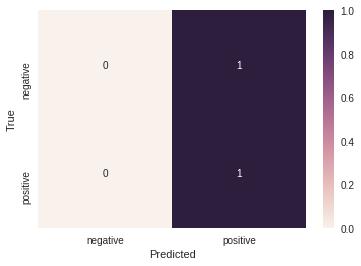

In [138]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(y_train, get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

In [10]:
df = df.sort_values(by=['ip','click_time'])
df['time_diff'] = df['click_time'].diff()
df.loc[df['ip'] != df['ip'].shift(), 'time_diff'] = None
df['time_diff'] = df.time_diff.dt.total_seconds()
df

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,time_diff
8192,195,9,1,18,215,2017-11-06 16:00:11,NaT,0,NaN
7999,247,2,1,17,477,2017-11-06 16:00:11,NaT,0,NaN
8464,365,15,1,27,245,2017-11-06 16:00:11,NaT,0,NaN
8574,439,3,1,22,280,2017-11-06 16:00:12,NaT,0,NaN
9021,439,12,1,22,265,2017-11-06 16:00:12,NaT,0,0.0
3356,563,12,1,13,140,2017-11-06 16:00:04,NaT,0,NaN
3363,563,9,1,13,442,2017-11-06 16:00:04,NaT,0,0.0
3366,563,1,1,13,153,2017-11-06 16:00:04,NaT,0,0.0
9198,596,13,1,607,400,2017-11-06 16:00:13,NaT,0,NaN
1623,728,27,1,19,122,2017-11-06 16:00:02,NaT,0,NaN
